# TCAV Implementing Experiment (Captum & ResNet18)

## Experiment Introduction

The goal of this experiment is to apply **TCAV** to a pre-trained **ResNet18** model and analyze how texture-based visual concepts influence the model's prediction of the **tiger** category in the ImageNet dataset.

This experiment aims to answer the following questions:

- Do texture-related concepts (e.g., striped patterns) significantly affect the classification of tigers?

- Does the influence of these concepts differ across network layers?

- Are the observed TCAV scores statistically significant compared to random concepts?

### Model and Dataset

- **Model:** ResNet18 pre-trained on ImageNet

- **Framework:** PyTorch, TorchVision, Captum

- **Target Category:** Tiger (ImageNet thesaurus *n02129604*)

- **Input Image:** ImageNet tiger samples, resized and normalized using standard ImageNet preprocessing methods

ResNet18 was chosen because of its relatively simple architecture and easily understandable hierarchical feature representations, making it suitable for interpretability analysis.

### Concept Definition

This experiment defines two types of concepts:

1. **Meaningful Texture Concepts**, including:

- *Striped*

- *Cracked*

- *Dotted*

- *Fiber-like*

- *Striped*

These concepts represent visually interpretable texture patterns that may be related to the appearance of an animal.

2. **Random Concepts**, as a control group:

- *random_0*

- *random_1*

- *random_2*

- *random_3*

The random concepts are constructed to have no semantic relationship with the target category and are used to verify that the observed TCAV effect is not caused by chance.

### TCAV Configuration

TCAV scores are calculated based on two intermediate convolutional layers of ResNet18:

- **layer2**, representing intermediate-level texture and pattern features

- **layer3**, representing higher-level semantic features

The **sign_count** metric is used as the primary evaluation metric, representing the proportion of inputs that have a positive impact on the target prediction.

### Experimental Design

The experiment consists of three phases:

1. **Experiment 1:**

A meaningful concept (e.g., *banded*, *lined*) is paired with a random concept to observe the effect of the basic concept.

2. **Experiment 2:**

Simultaneously compare multiple texture-based concepts and randomized concepts to examine the relative importance between layers.

3. **Statistical Significance Test:**

Use a two-tailed t-test to compare the TCAV scores of meaningful concepts with a randomized baseline.

Visualize the score distribution using box plots and assess whether the observed differences are statistically significant.

## Imports

In [1]:
import os, glob, time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import ttest_ind

import torch
import torchvision
from torchvision import transforms
from torchvision.models import ResNet18_Weights

from captum.attr import LayerIntegratedGradients
from captum.concept import TCAV, Concept
from captum.concept._utils.data_iterator import (
    dataset_to_dataloader, CustomIterableDataset
)
from captum.concept._utils.common import concepts_to_str

/opt/anaconda3/envs/captum_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Image Preprocessing

All images are resized and normalized using ImageNet statistics
to match the input requirements of ResNet18.

In [2]:
def transform(img: Image.Image) -> torch.Tensor:
    tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return tf(img)

## Helper Functions

Utilities for loading images and assembling TCAV concepts.

In [3]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path, apply_transform=True):
    path = os.path.join(root_path, class_name)
    files = glob.glob(os.path.join(path, "*.JPEG"))

    images = []
    for f in files:
        img = Image.open(f).convert("RGB")
        images.append(transform(img) if apply_transform else img)
    return images


def assemble_concept(name, cid, concepts_path):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    data_iter = dataset_to_dataloader(dataset)
    return Concept(id=cid, name=name, data_iter=data_iter)

## Load Concepts

We define texture-based concepts and several random concepts
used as control groups in TCAV experiments.

In [4]:
concepts_path = "data/tcav_exp/image/concepts/"

banded = assemble_concept("banded", 0, concepts_path)
cracked = assemble_concept("cracked", 1, concepts_path)
dotted = assemble_concept("dotted", 2, concepts_path)
fibrous = assemble_concept("fibrous", 3, concepts_path)
lined = assemble_concept("lined", 4, concepts_path)

random_0 = assemble_concept("random_0", 5, concepts_path)
random_1 = assemble_concept("random_1", 6, concepts_path)
random_2 = assemble_concept("random_2", 7, concepts_path)
random_3 = assemble_concept("random_3", 8, concepts_path)

## Load Target Class: Tiger

Tiger images are sampled from ImageNet synset **n02129604**.

In [5]:
imagenet_root = "data/tcav_exp/image/imagenet/"
tiger_imgs = load_image_tensors("tiger", imagenet_root, apply_transform=False)
tiger_tensors = torch.stack([transform(img) for img in tiger_imgs])

## Model Initialization

We use a pretrained ResNet18 model from TorchVision.

In [6]:
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()

labels = ResNet18_Weights.DEFAULT.meta["categories"]
tiger_ind = labels.index("tiger")

## TCAV Setup

We compute TCAV scores on intermediate convolutional layers.

In [7]:
layers = ["layer2", "layer3"]

tcav = TCAV(
    model=model,
    layers=layers,
    layer_attr_method=LayerIntegratedGradients(
        model, None, multiply_by_inputs=False
    )
)

/opt/anaconda3/envs/captum_env/lib/python3.10/site-packages/captum/concept/_core/tcav.py:325: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  self.classifier = DefaultClassifier()


## Define Experimental Sets 1

In [8]:
experimental_sets_1 = [
    [banded, random_0],
    [banded, random_1],
    [lined, random_0],
    [lined, random_1],
]

## Run TCAV Experiment 1

In [10]:
start = time.time()
tcav_scores = tcav.interpret(
    inputs = tiger_tensors,
    experimental_sets = experimental_sets_1,
    target = tiger_ind,
    n_steps = 5
)
print("Time taken:", time.time() - start, "s")

/opt/anaconda3/envs/captum_env/lib/python3.10/site-packages/captum/_utils/models/linear_model/train.py:409: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


Time taken: 58.34040904045105 s


## Visualization Functions

In [11]:
def format_float(f):
    return float("{:.3f}".format(f)) if abs(f) >= 5e-4 else float("{:.3e}".format(f))


def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize=(25, 7))
    bar_width = 1 / (len(experimental_sets[0]) + 1)

    for idx, concepts in enumerate(experimental_sets):
        key = concepts_to_str(concepts)
        positions = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            positions.append([x + bar_width for x in positions[i-1]])

        cur_ax = ax[idx] if len(experimental_sets) > 1 else ax
        for i, concept in enumerate(concepts):
            values = [
                format_float(scores["sign_count"][i])
                for scores in tcav_scores[key].values()
            ]
            cur_ax.bar(positions[i], values, width=bar_width, label=concept.name)

        cur_ax.set_xticks([r + bar_width for r in range(len(layers))])
        cur_ax.set_xticklabels(layers)
        cur_ax.legend()

    plt.show()

## Visualization of Experiment 1

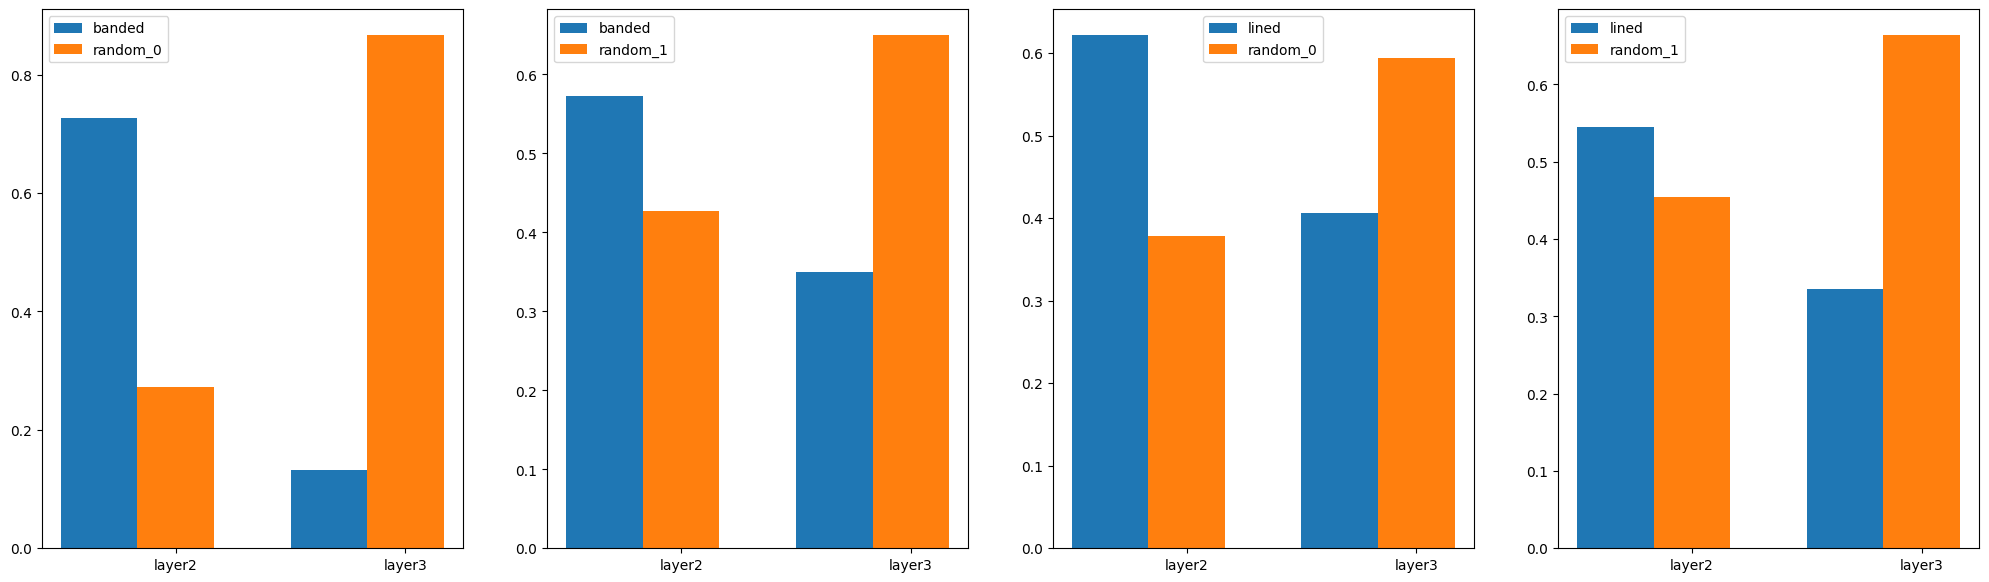

In [14]:
plot_tcav_scores(experimental_sets_1, tcav_scores)

### Experiment 1 Results

The TCAV sign_count results show that in Layer 2, banded and line-like concepts generally score higher than random concepts, indicating that texture-related features contribute positively to tiger classification in the intermediate layers.

In Layer 3, this advantage weakens or becomes unstable, suggesting that deeper models rely less on texture cues and more on higher-level semantic information.

## Define Experimental Sets 2

In [15]:
experimental_set_2 = [
    [
        banded,
        cracked,
        dotted,
        fibrous,
        lined,
        random_0,
        random_1,
        random_2,
        random_3,
    ]
]

## Run TCAV Experiment 2

In [16]:
start = time.time()
tcav_scores_2 = tcav.interpret(
    inputs = tiger_tensors,
    experimental_sets = experimental_set_2,
    target = tiger_ind,
    n_steps = 5
)
end = time.time()
print("time taken: ", end - start)

time taken:  68.85473203659058


## Visualization of Experiment 2

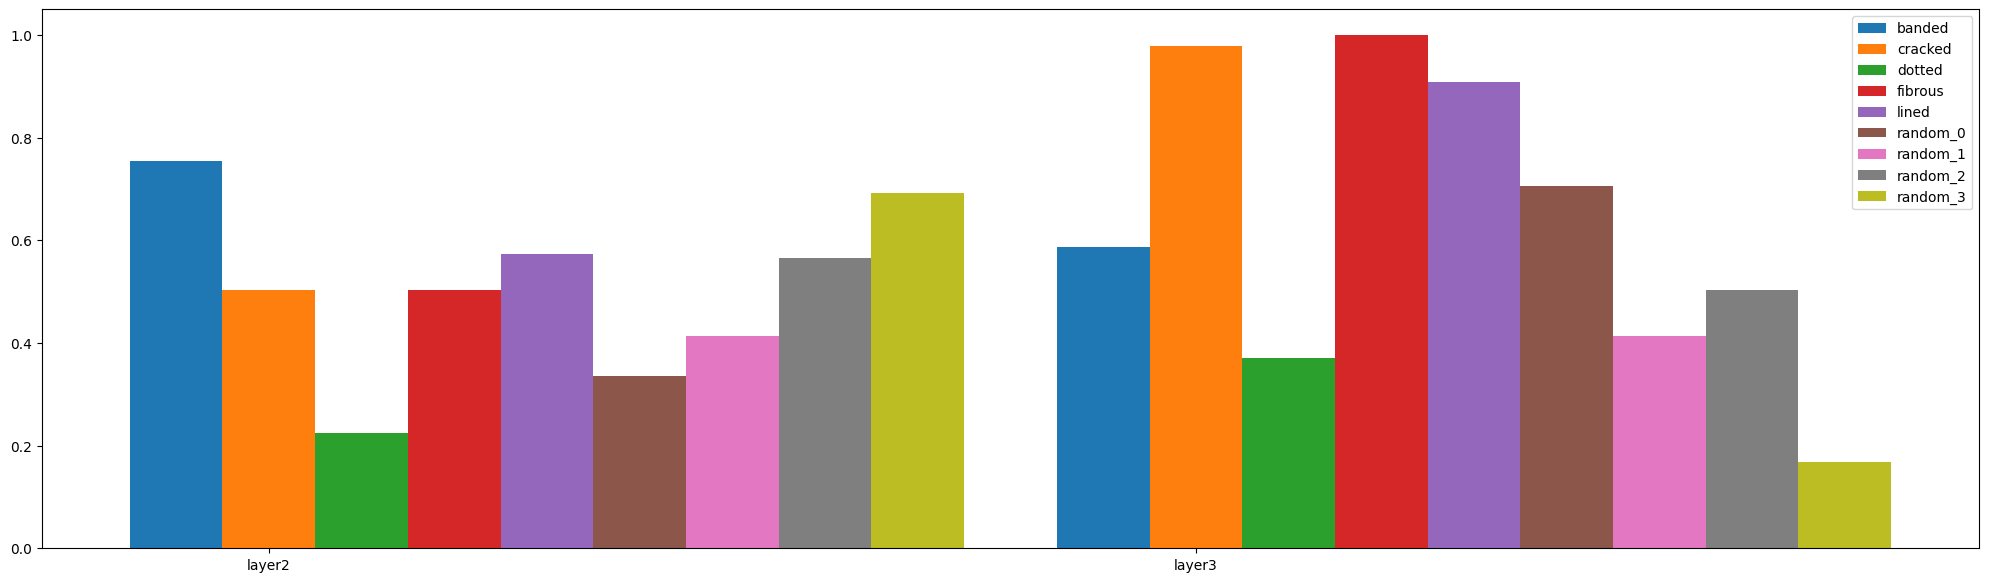

In [17]:
plot_tcav_scores(experimental_set_2, tcav_scores_2)

### Experiment 2 Results

Across multiple concepts, Layer 2 scored higher on TCAV symbol counts for texture-related concepts (e.g., striped and fibrous), indicating that mid-layer features can capture informative local texture patterns for tiger classification.

In Layer 3, scores varied significantly across different concepts, with no single texture consistently dominating. This suggests that deeper layers rely on more diverse, higher-level semantic representations rather than single texture cues.

# Statistical Significance Testing of TCAV Scores

To verify that the observed TCAV scores reflect meaningful concept influence
rather than random fluctuations, we perform statistical significance testing.

We compare TCAV scores of a target concept (e.g. banded, lined) against
random concepts using two-sided t-tests.

If the p-value is smaller than 0.05, we reject the null hypothesis and
conclude that the concept has a statistically significant influence
on the model's prediction.

In [18]:
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        key = "-".join([str(c.id) for c in concepts])
        score_list.append(scores[key][score_layer][score_type][idx])
    return score_list


def get_pval(scores, experimental_sets, score_layer, score_type,
             alpha=0.05, print_ret=True):
    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)

    _, pval = ttest_ind(P1, P2)

    relation = "Disjoint" if pval < alpha else "Overlap"

    if print_ret:
        print(f"Layer: {score_layer}")
        print(f"P1 mean/std: {np.mean(P1):.3f} / {np.std(P1):.3f}")
        print(f"P2 mean/std: {np.mean(P2):.3f} / {np.std(P2):.3f}")
        print(f"p-value: {pval:.4f} → {relation}")
        print("-" * 40)

    return P1, P2, pval, relation

### Construct Experimental Sets

Each experimental set compares a meaningful concept with a random concept.
Multiple random concepts are used to ensure robustness.

In [19]:
experimental_sets_3 = [
    [banded, random_0],
    [banded, random_1],
    [banded, random_2],
    [banded, random_3],

    [random_0, random_1],
    [random_0, random_2],
    [random_0, random_3],
]

### Run TCAV for Statistical Testing

In [20]:
tcav_scores_3 = tcav.interpret(
    inputs = tiger_tensors,
    experimental_sets = experimental_sets_3,
    target = tiger_ind,
    n_steps = 5
)

## Statistical Test Results (Sign Count Metric)

### Visualization of Statistical Significance (Boxplots)

To further analyze the statistical significance of TCAV scores, we visualize
their distributions using boxplots.

For each layer, we compare the TCAV score distributions of a meaningful concept
(e.g. banded) against random concepts.

If the two distributions are disjoint and the p-value is smaller than 0.05,
we conclude that the concept has a statistically significant influence.

In [22]:
def show_boxplots(
    scores,
    experimental_sets,
    layer,
    metric="sign_count",
    n_per_plot=4,
    ylim=(0, 1)
):

    def label_names(exp_set):
        return [
            exp_set[0].name,
            exp_set[1].name.split("_")[0] + "_rand"
        ]

    n_plots = len(experimental_sets) // n_per_plot
    fig, axes = plt.subplots(1, n_plots, figsize = (25, 6))
    if n_plots == 1:
        axes = [axes]

    for i in range(n_plots):
        es_slice = experimental_sets[i * n_per_plot : (i + 1) * n_per_plot]

        P1, P2, pval, relation = get_pval(
            scores = scores,
            experimental_sets = es_slice,
            score_layer = layer,
            score_type = metric,
            alpha = 0.05,
            print_ret = False
        )

        axes[i].boxplot([P1, P2], showfliers = True)
        axes[i].set_ylim(ylim)
        axes[i].set_title(
            f"{layer} | {metric}\n(p = {pval}, {relation})",
            fontsize = 16
        )
        axes[i].set_xticklabels(label_names(es_slice[0]), fontsize = 14)
        axes[i].grid(axis = "y", linestyle = "--", alpha = 0.5)

    plt.show()

### Boxplots for Each Layer

Below we visualize TCAV score distributions for each selected layer.

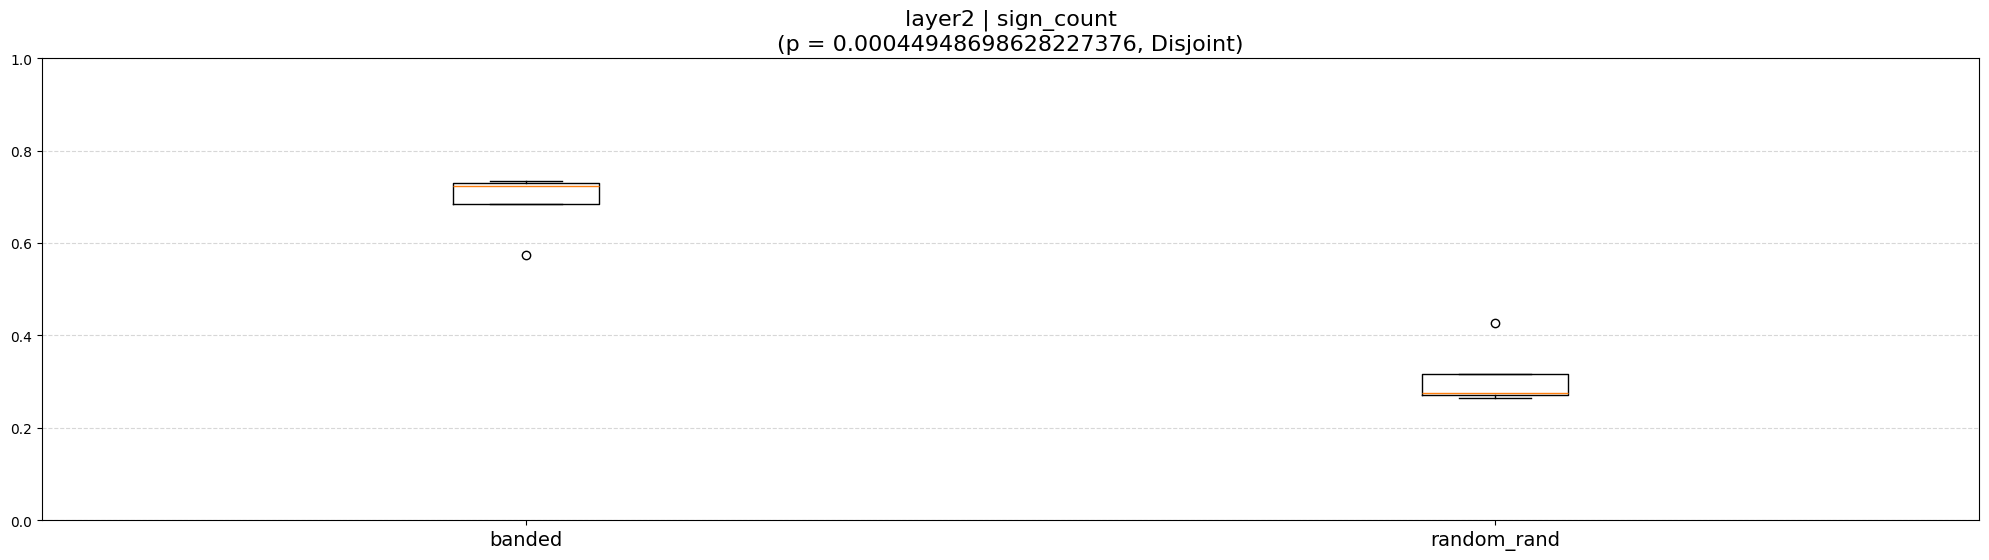

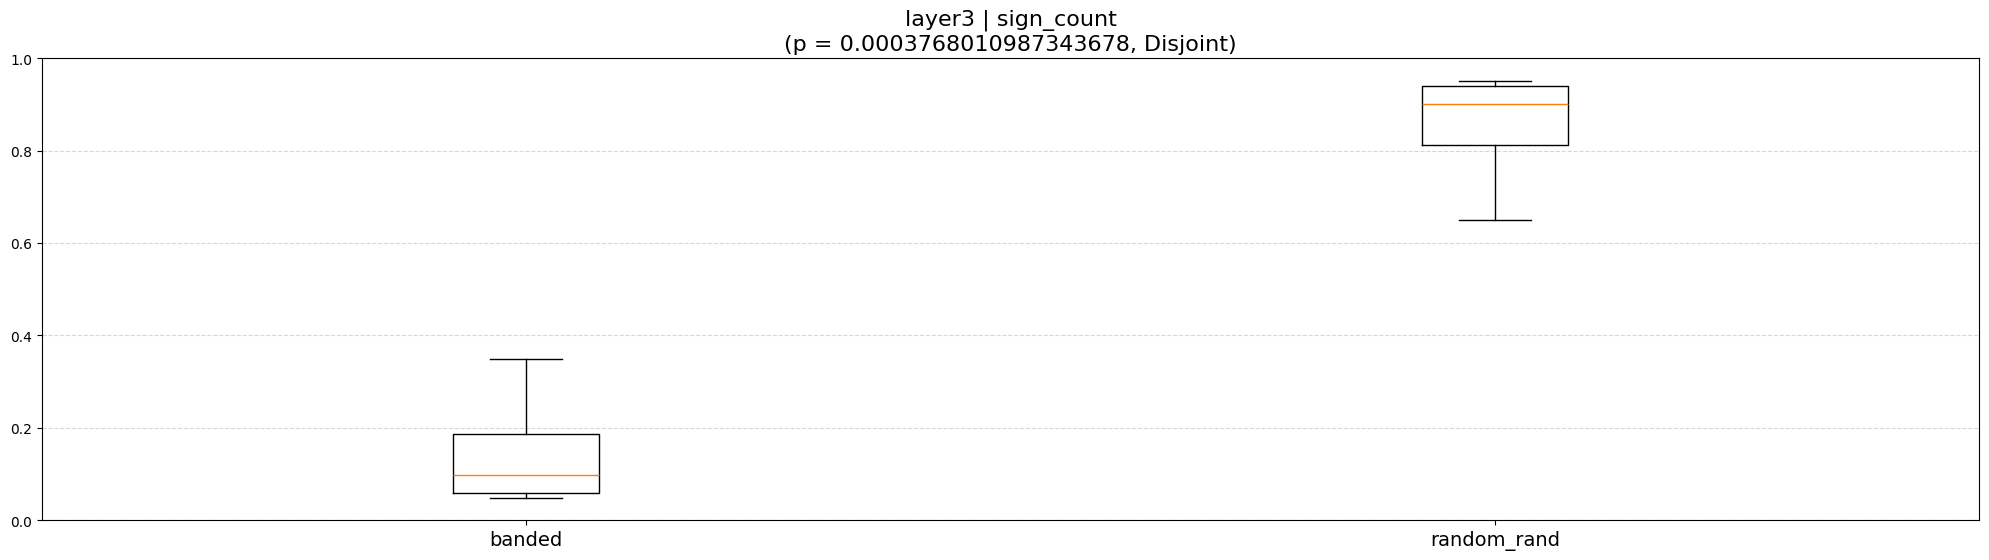

In [23]:
for layer in layers:
    show_boxplots(
        scores = tcav_scores_3,
        experimental_sets = experimental_sets_3,
        layer = layer,
        metric = "sign_count",
        n_per_plot = 4
    )

## Results and Interpretation

### TCAV Statistical Results for Tiger Category

The figure above shows a boxplot visualization of the TCAV **sign_count** scores for striped and random concepts in the two intermediate layers (layer2 and layer3) of ResNet18. Statistical significance was assessed using a two-tailed t-test with a significance level of 0.05.

### Layer 2 (Intermediate Feature Layer)

In layer 2, the TCAV **sign_count** score for the striped concept is consistently higher than the random baseline.

The distributions are clearly separated, and the p-value of the t-test is very small. Therefore, the null hypothesis is rejected.

This indicates that striped texture contributes positively to the model’s prediction of the tiger category in layer 2.

### Layer 3 (Deeper Semantic Layer)

In layer 3, the TCAV **sign_count** distribution for striped concepts is lower than that of the random concept baseline.

This result indicates that striped texture is informative in earlier stages, but its contribution diminishes as layer depth increases.

At this stage, the network may rely more on higher-level semantic features, such as overall shape, body structure, or object configuration, rather than isolated texture cues.

### Summary

Overall, the results show that the influence of the striped concept on tiger classification is **layer-dependent**:

- The concept has a positive effect in intermediate layers.
- Its effect weakens or reverses in deeper layers.
- All observed differences are statistically significant, suggesting that these effects are unlikely to be caused by random variation.

These findings are consistent with the hierarchical feature abstraction behavior of convolutional neural networks and support the effectiveness of TCAV as a concept-level interpretability tool.